In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [2]:
from pathlib import Path
data_dir = Path("PCB_DATASET")
os.listdir(data_dir)


['Annotations', 'images', 'PCB_USED', 'rotate.py', 'rotation']

In [3]:
%matplotlib inline

In [4]:
from PIL import Image
template_dir=os.path.join(data_dir,'PCB_USED')
def visualize_img(dir_name,nos_):
    k=1
    plt.figure(figsize=(8,(nos_//2)*5))
    for filename in os.listdir(dir_name)[0:nos_]:
        if filename.lower().endswith(('.jpg','.jpeg','.png')):
            ax=plt.subplot((nos_//2)+1,2,k)
            img_path=os.path.join(dir_name,filename)
            img=plt.imread(img_path)
            ax.imshow(img)
            ax.set_xlabel(filename)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            k+=1
    plt.tight_layout()
    plt.show()
        

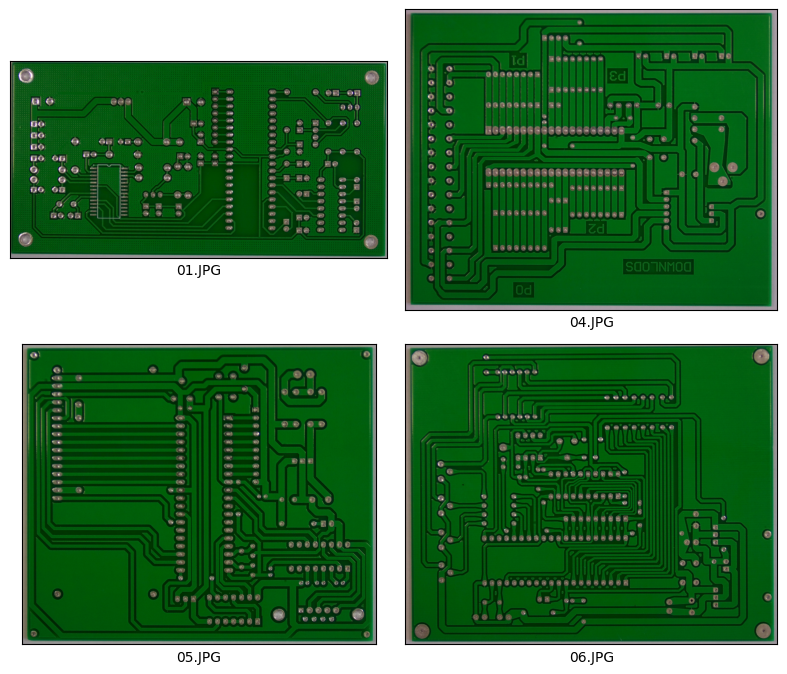

No of template images:10


In [5]:
visualize_img(template_dir,nos_=4)

print(f'No of template images:{len(os.listdir(template_dir))}')

In [6]:
img_dir = os.path.join(data_dir, 'images')
ann_dir = os.path.join(data_dir, 'Annotations')
ann_cat = os.listdir(ann_dir)

In [22]:
root_dir=os.getcwd()

In [9]:
os.makedirs(os.path.join(root_dir,'yolo_dataset'),exist_ok=True)
dataset_dir=os.path.join(root_dir,'yolo_dataset')
yolo_images_dir = os.path.join(dataset_dir, 'images')
yolo_labels_dir = os.path.join(dataset_dir, 'labels')
os.makedirs(yolo_images_dir,exist_ok=True)
os.makedirs(yolo_labels_dir,exist_ok=True)

In [11]:
from pathlib import Path
i = 0
img_path = Path(img_dir)
for item in list(img_path.rglob('*.jpg')):
    i+=1
print(i)

j = 0
ann_path = Path(ann_dir)
for item in list(ann_path.rglob("*.xml")):
    j+=1
print(j)

693
693


In [ ]:
import xml.etree.ElementTree as ET

def parseXML(file, target_size = (640, 640)):
    output = []
    tree = ET.parse(file)
    root = tree.getroot()
    filename = root.find('filename')
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    class_map = {'spurious_copper': 0,
                 'short': 1,
                 'spur_': 2, #added '_' to distinguish from spurious copper
                 'open_circuit': 3,
                 'mouse_bite': 4,
                 'missing_hole': 5
                 }
    for key in class_map:
        if key in filename.text:
            cat = class_map[key]

    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    width_ratio = target_size[0] / width
    height_ratio = target_size[1] / height

    width = target_size[0]
    height = target_size[1]

    label_filename = (filename.text).split('.jpg')[0] + '.txt'
    label_path = os.path.join(yolo_labels_dir, label_filename)

    with open(label_path, 'w') as f:
        for obj in root.findall('object'):
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            xmin = int(xmin * width_ratio)
            ymin = int(ymin * height_ratio)
            xmax = int(xmax * width_ratio)
            ymax = int(ymax * height_ratio)

            x_center = (xmax + xmin) / 2 / width
            y_center = (ymax + ymin) / 2 / height
            b_width = (xmax - xmin) / width
            b_height = (ymax - ymin) / height

            f.write(f"{cat} {x_center:.6f} {y_center:.6f} {b_width:.6f} {b_height:.6f}\n")


In [53]:
def parseFolder(input_dir):
    for path in list(Path(input_dir).rglob('*.xml')):
        parseXML(path)

parseFolder(ann_dir)

In [51]:
def uniform_size_img(input_dir, output_dir, size = (640, 640)):
    for path in list(Path(input_dir).rglob('*.jpg')):
        image = cv2.imread(str(path))
        new_img = cv2.resize(image, size)
        filename = Path(path).name
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, new_img)
uniform_size_img(img_dir, yolo_images_dir)

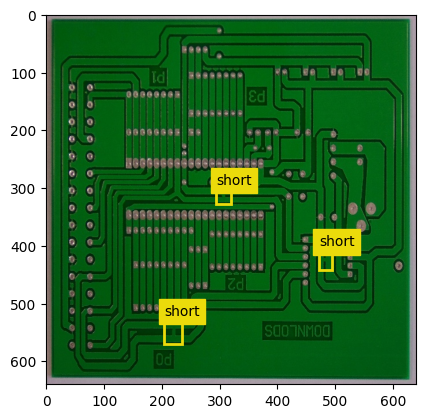

In [17]:
from ultralytics.data.utils import visualize_image_annotations
cat_dict = ['spurious_copper','short','spur_','open_circuit','mouse_bite','missing_hole']
visualize_image_annotations(
    os.path.join(yolo_images_dir, "train\\04_short_03.jpg"),
    os.path.join(yolo_labels_dir, "train\\04_short_03.txt"),
    cat_dict,
)

In [ ]:
test_dataset_dir = os.path.join(root_dir, "yolo_test_dataset")
os.makedirs(test_dataset_dir,exist_ok=True)

In [ ]:
import random
import shutil
import yaml

class_names = ['spurious_copper', 'short', 'spur', 'open_circuit', 'mouse_bite', 'missing_hole']
split_ratios = {'train': 0.7, 'val': 0.2, 'test': 0.1}

for split in ['train', 'val']:
    Path(f"{yolo_images_dir}/{split}").mkdir(parents=True, exist_ok=True)
    Path(f"{yolo_labels_dir}/{split}").mkdir(parents=True, exist_ok=True)

Path(f"{test_dataset_dir}/images").mkdir(parents=True, exist_ok=True)
Path(f"{test_dataset_dir}/labels").mkdir(parents=True, exist_ok=True)

image_files = list(Path(yolo_images_dir).rglob("*.jpg"))
dataset = [(img, Path(yolo_labels_dir) / (img.stem + ".txt")) for img in image_files if (Path(yolo_labels_dir) / (img.stem + ".txt")).exists()]

random.shuffle(dataset)
total = len(dataset)
train_end = int(split_ratios['train'] * total)
val_end = train_end + int(split_ratios['val'] * total)

split_map = {
    'train': dataset[:train_end],
    'val': dataset[train_end:val_end],
    'test': dataset[val_end:]
}

for split in ['train', 'val']:
    for img_path, label_path in split_map[split]:
        shutil.move(str(img_path), f"{yolo_images_dir}/{split}/{img_path.name}")
        shutil.move(str(label_path), f"{yolo_labels_dir}/{split}/{label_path.name}")

for img_path, label_path in split_map['test']:
    shutil.move(str(img_path), f"{test_dataset_dir}/images/{img_path.name}")
    shutil.move(str(label_path), f"{test_dataset_dir}/labels/{label_path.name}")

data_yaml = {
    'train': str(Path(f"{yolo_images_dir}/train").resolve()),
    'val': str(Path(f"{yolo_images_dir}/val").resolve()),
    'nc': len(class_names),
    'names': class_names
}

with open(f"{dataset_dir}/data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

print(f"Train: {len(split_map['train'])}, Val: {len(split_map['val'])}, Test: {len(split_map['test'])}")
print(f"Test set saved in: {test_dataset_dir}/images and {test_dataset_dir}/labels")
print(f"data.yaml created at: {dataset_dir}/data.yaml")
